# ML Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as sklm
from sklearn.dummy import DummyClassifier
import random
import metoder
import pandas as pd

Importing dataset:

In [2]:
#path:
#file_path = r"C:\Users\vikto\Documents\Skole\Datadrevne_systemer\ML_Project\glass_data-4_lev.csv"
file_path_training = "../Datasett/train_set.csv"
file_path_test = "../Datasett/test_set.csv"
file_path_total_set =   "../Datasett/mushrooms.csv"
#importing file and print how the structure of data were inported. 
df_training = pd.read_csv(file_path_training)
df_test = pd.read_csv(file_path_test)
df_total = pd.read_csv(file_path_total_set)

drop_list = ['capColor','odor','gillColor','stalkColorAboveRing','stalkColorBelowRing','veilType','sporePrintColor','population','habitat']

df_training = df_training.drop(columns=drop_list)
df_test = df_test.drop(columns=drop_list)
df_total = df_total.drop(columns=drop_list)


#drop ID number
#df = df.drop(columns=['Id'])

print(df_total['class'].dtype)
df_total.info()

object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   class                  8124 non-null   object
 1   capShape               8124 non-null   object
 2   capSurface             8124 non-null   object
 3   bruises                8124 non-null   object
 4   gillAttachment         8124 non-null   object
 5   gillSpacing            8124 non-null   object
 6   gillSize               8124 non-null   object
 7   stalkShape             8124 non-null   object
 8   stalkRoot              8124 non-null   object
 9   stalkSurfaceAboveRing  8124 non-null   object
 10  stalkSurfaceBelowRing  8124 non-null   object
 11  veilColor              8124 non-null   object
 12  ringNumber             8124 non-null   object
 13  ringType               8124 non-null   object
dtypes: object(14)
memory usage: 888.7+ KB


### Small exploration of data:

In [3]:
# Check the number of unique rows in the DataFrame
num_unique_rows = df_total.drop_duplicates().shape[0]

# Print the result
print("Number of unique rows:", num_unique_rows)

Number of unique rows: 183


The data set clearly shows that T1, T2 is most frequently. 

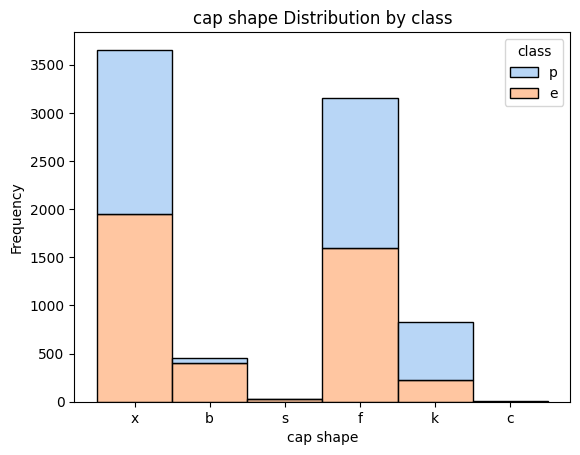

In [4]:
# Create a histogram of age with hue for income
sns.histplot(data=df_total, x='capShape', hue='class', multiple='stack', palette='pastel')

# Add labels and title
plt.xlabel('cap shape')
plt.ylabel('Frequency')
plt.title('cap shape Distribution by class')

# Show the plot
plt.show()

In [5]:
#for col in df.columns[:-1]:  # Exclude the 'Type' column
 #   sns.boxplot(x='Type', y=col, data=df)
  #  plt.show()

One-hot encoding to ensure the best result

In [6]:
# Perform one-hot encoding for all categorical columns except the "class" column
# Perform one-hot encoding for all categorical columns except the "class" column
df_train_encoded = pd.get_dummies(df_training, columns=df_training.drop(columns=['class']).columns.tolist())
df_test_encoded = pd.get_dummies(df_test, columns=df_test.drop(columns=['class']).columns.tolist())

# Replace "p" with 1 and "e" with 0 in the "class" column in the df_training and df_test DataFrames
df_train_encoded['class'] = df_train_encoded['class'].apply(lambda x: 1 if x == 'p' else 0)
df_test_encoded['class'] = df_test_encoded['class'].apply(lambda x: 1 if x == 'p' else 0)

# Splitting into features (X) and target variable (y)
X_train, y_train = df_train_encoded.drop(['class'], axis=1), df_train_encoded['class']
X_test, y_test = df_test_encoded.drop(['class'], axis=1), df_test_encoded['class']

print(y_train.unique())  # Display unique values in y_train
print(y_test.unique())

y_train = y_train.astype(int)
y_test = y_test.astype(int)

[1 0]
[0 1]


### Make a neural network:

Split data to training and validation and Scale the data: 

Epoch 1/10
204/204 [==============================] - 1s 2ms/step - loss: 0.1855 - accuracy: 0.9357 - val_loss: 0.0591 - val_accuracy: 0.9846
Epoch 2/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0352 - accuracy: 0.9889 - val_loss: 0.0203 - val_accuracy: 0.9951
Epoch 3/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.0119 - val_accuracy: 0.9975
Epoch 4/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.0107 - val_accuracy: 0.9951
Epoch 5/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0092 - val_accuracy: 0.9963
Epoch 6/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0147 - val_accuracy: 0.9951
Epoch 7/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.9971 - val_loss: 0.0063 - val_accuracy: 0.9982
Epoch 

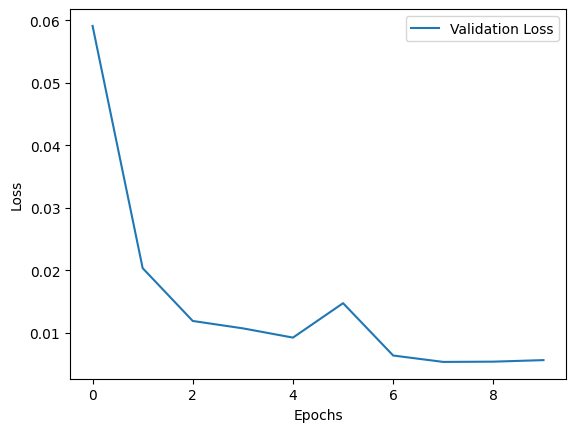

In [7]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and get the training history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict
y_pred = model.predict(X_test)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype("int32")

# Plot the validation loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate model:

In [8]:
# Results storage as a dictionary
results = {}

#neural network:
# Create confusion matrix and normalize it over predicted (columns)
cm = sklm.confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = sklm.accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

results['neuralnetwork'] = {'accuracy': accuracy, 'confusion_matrix': cm}

Confusion Matrix:
[[841   2]
 [  5 777]]
Accuracy: 0.9956923076923077


In [9]:
# Call each function and store the results
accuracy, cm = metoder.randomforest(X_train, X_test, y_train, y_test)
results['randomforest'] = {'accuracy': accuracy, 'confusion_matrix': cm}

In [10]:
accuracy, cm = metoder.gradientboost(X_train, X_test, y_train, y_test)
results['gradientboost'] = {'accuracy': accuracy, 'confusion_matrix': cm}

In [11]:
#accuracy, confusion_matrix = metoder.linearregression(X_train, X_test, y_train, y_test)
#results['linearregression'] = {'accuracy': accuracy, 'confusion_matrix': confusion_matrix}


In [12]:
accuracy, cm= metoder.decisionregressor(X_train, X_test, y_train, y_test)
results['decisionregressor'] = {'accuracy': accuracy, 'confusion_matrix':cm}

In [13]:
#accuracy, cm = metoder.mlpregression(X_train, X_test, y_train, y_test)
#results['mlpregression'] = {'accuracy': accuracy, 'confusion_matrix': cm}

In [14]:
accuracy, cm = metoder.supportvectorclassifier(X_train, X_test, y_train, y_test)
results['supportvectoregressor'] = {'accuracy': accuracy, 'confusion_matrix': cm}

In [15]:

accuracy, cm = metoder.kneighborsclassifier(X_train, X_test, y_train, y_test)
results['kneighborsregressor'] = {'accuracy': accuracy, 'confusion_matrix': cm}

In [16]:
#make tree lists of dictionary: 
algorithm_names = []
accuracies = []
confusion_matrices_list = []

for algorithm, results_info in results.items():
    algorithm_names.append(algorithm)
    accuracies.append(results_info['accuracy'])
    confusion_matrices_list.append(results_info['confusion_matrix'])


In [17]:
compare_models = pd.DataFrame({ "Algorithms": algorithm_names, "accuracy": accuracies})
compare_models.sort_values(by = "accuracy", ascending = False)

,Algorithms,accuracy
1,randomforest,0.998154
3,decisionregressor,0.998154
4,supportvectoregressor,0.998154
0,neuralnetwork,0.995692
5,kneighborsregressor,0.995077
2,gradientboost,0.992000


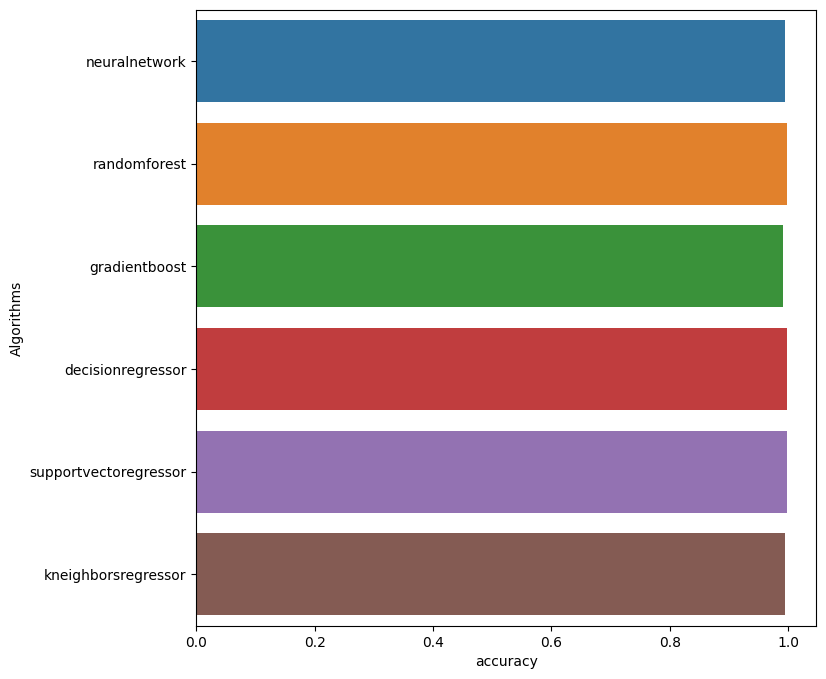

In [18]:
%matplotlib inline
plt.figure(figsize=(8,8))
sns.barplot(x = "accuracy", y = "Algorithms", data = compare_models)
plt.show()

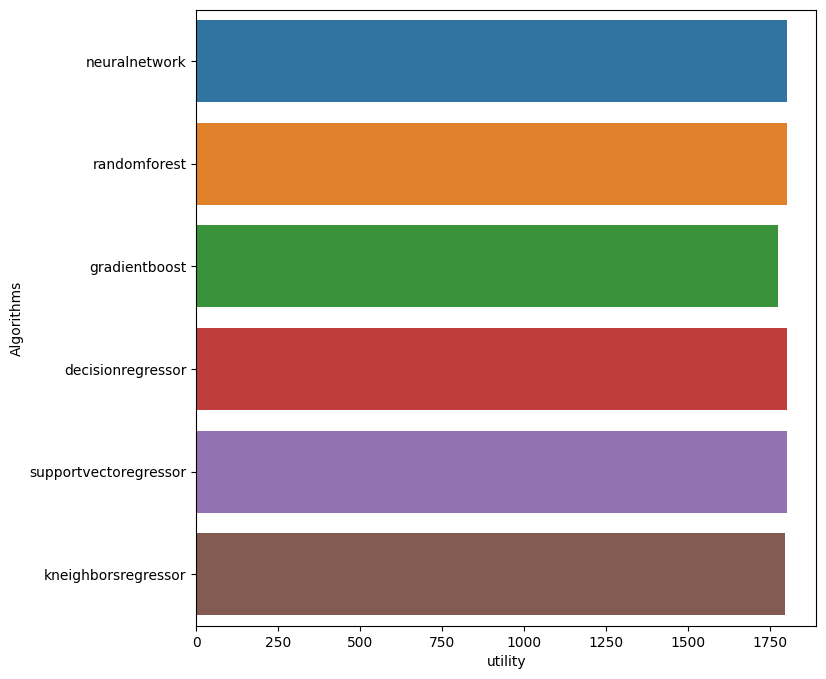

In [19]:
# Utility Evaluation 

ulitity_matrix = np.array([[1.5, -2],
                           [-0.2 , 0.7]])

print()
ulitity_score =[] 

for i in range(len(algorithm_names)):
    ulitity_score.append(np.sum(np.array(confusion_matrices_list[i])*ulitity_matrix))
    

compare_models = pd.DataFrame({ "Algorithms": algorithm_names, "utility": ulitity_score})
compare_models.sort_values(by = "utility", ascending = False)

%matplotlib inline
plt.figure(figsize=(8,8))
sns.barplot(x = "utility", y = "Algorithms", data = compare_models)
plt.show()

